In [1]:
# %load_ext rpy2.ipython
# %load_ext RWinOut # hack to see the output, https://github.com/vitorcurtis/RWinOut

In [1]:
from itertools import product, accumulate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, minmax_scale
from sklearn.linear_model import LinearRegression

from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles, MolToSmiles, MolToInchi, InchiToInchiKey, PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools

from tqdm import tqdm_notebook
pd.set_option('display.max_columns', 500)

## Load the data

In [2]:
df_clean = pd.read_csv('secondary_data/df_clean.csv', index_col=0)
df_molecules_std = pd.read_csv('secondary_data/df_molecules_std.csv', index_col=0)
df_activity = pd.read_csv('secondary_data/df_activity.csv', index_col=0)

In [3]:
PandasTools.AddMoleculeColumnToFrame(df_molecules_std,smilesCol='std_smiles', molCol='mol')

In [4]:
df_join = df_activity.join(df_molecules_std, on='std_inchi_key')
df_join.rename(lambda x:x.replace('pChEMBL_Value', 'activity'), axis='columns', inplace=True)

,receptor_name,Standard_Value,activity,std_smiles,std_inchi,std_morgan_fp,scaffold_smiles,scaffold_inchi,scaffold_inchi_key,scaffold_morgan_fp,mol
std_inchi_key,,,,,,,,,,,
AABLNHSZFIPOBJ-UHFFFAOYSA-N,GR,31.00,7.510,O=c1[nH]c(N2CCC(c3ccccc3)CC2)c(Cc2ccc(Cl)cc2)c(=O)[nH]1,"InChI=1S/C22H22ClN3O2/c23-18-8-6-15(7-9-18)14-19-20(24-22(28)25-21(19)27)26-12-10-17(11-13-26)16-4-2-1-3-5-16/h1-9,17H,10-14H2,(H2,24,25,27,28)",0000000000010000000000010000000000000001000000100000000000000000100000000000000010000000001000000000000000000000000000000000000000000010000000000000000000000000000000000000000100000000000000000000000000000000000000001000000000000000000000000000000000000001000100000000000000000000000000000000000000000100000000100010000000000000000000010000000000000000000010000000000000000000000000000000010000000000000000110000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000010000000000000000000000000000000000001000000000010000001010000000000000000000000000000000000000000000000000000000000000101001000100000000000000000001000000000000000001000000000000000000000000000010000100000000000001000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000010000000010000000000000000000000000000000000000000100010000000000000000000001000000010000000010000,CC1CC(C)C(CC2CCCCC2)C(C2CCC(C3CCCCC3)CC2)C1,"InChI=1S/C27H48/c1-20-17-21(2)26(19-22-9-5-3-6-10-22)27(18-20)25-15-13-24(14-16-25)23-11-7-4-8-12-23/h20-27H,3-19H2,1-2H3",DNUKMHCVRXGROZ-UHFFFAOYSA-N,0010100000000000000000000000010001000000000001000000000000000000000000000000000010000000010000000000000000000000000000001000100000000000000000000000000010000000000000000000000000000000001000000000000010000000000000000000000000000000000000000000000000000000000000010000100000001000000001000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000100000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000010000000000000000000000000000000000010000000000001000000000000000000000000001000000000000000000000000000000000000000000000000100010001,
AACVSEPXXNRBIR-UHFFFAOYSA-N,PR,16.40,7.790,COC1Oc2ccc(Cl)cc2-c2ccc3c(c21)C(C)=CC(C)(C)N3,"InChI=1S/C20H20ClNO2/c1-11-10-20(2,3)22-15-7-6-13-14-9-12(21)5-8-16(14)24-19(23-4)18(13)17(11)15/h5-10,19,22H,1-4H3",0000000000010000000000000000000001001000000000000000000000000000000000000010000000000000001000000000000000100000000000000000000100000000000100000000000000000000000001000000000000000000000000000000000000000000000000001000000000000000000000000000010000100000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000100010000000000000000000000000000000000000100000000000000000000000000000000000001000000000100000000000000000000000000000000000000000000000000000000000010000000000010000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000001000000000110000000010000000000010010000000000000000000010000000000000010010000000000000000000000001001000000000000000001000001000000000000000000000000000000000000000000000000000000000000000001000000000000000000000001101000001000000000000000000000000010000010010000000000000000000000000000000000000000000000000000100000000000000000000100000000000000000000000000000000001000000000100000000000000010000,C1CCC2C(C1)CCC1C3CCCCC3CCC21,"InChI=1S/C18H30/c1-3-7-15-13(5-1)9-11-18-16-8-4-2-6-14(16)10-12-17(15)18/h
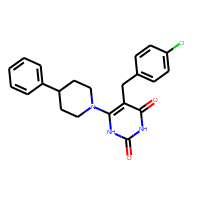
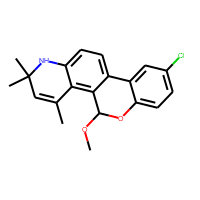
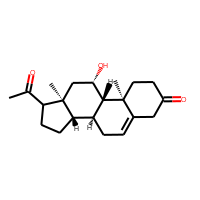
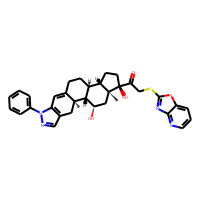
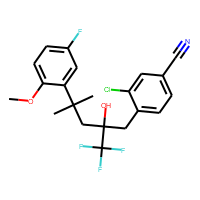

In [5]:
df_join.head()

## Exploratory analysis

In [6]:
def plot_kde(x, num_points=1000, *args, **kwargs):
    density = gaussian_kde(x)
    x = np.linspace(np.min(x), np.max(x), num_points)
    plt.plot(x, density(x), *args, **kwargs)

In [7]:
def plot_kde_2d(p_x,p_y, num_points=100, bw_method=None, *args, **kwargs):
    density = gaussian_kde(np.c_[p_x, p_y].T, bw_method)
    x,y = np.linspace(np.min(p_x),np.max(p_x), num_points), np.linspace(np.min(p_y), np.max(p_y), num_points)
    z = density(np.asarray(list(product(x,y))).T).reshape(num_points,num_points).T
#     z = density(list(zip(*product(x,y)))).reshape(num_points,num_points).T
    plt.pcolormesh(x,y,z, *args, **kwargs)

In [8]:
from matplotlib import cm

def make_colormap(x, colormap=cm.plasma):
    return colormap(np.int64(minmax_scale(x)*255))

def plot_scatter_colormap(x,y,z,alpha=0.25,*args,**kwargs):
#     plt.figure()
    plt.scatter(x,y, c=make_colormap(z), alpha=alpha, *args, **kwargs)
    plt.figure()
    plt.axis('off')
    plt.imshow(np.expand_dims(np.asarray(cm.plasma.colors),0),aspect=10)

In [9]:
def plot_linear_regression(x,y,alpha=0.1,*args,**kwargs):
    lr = linregress(x,y)
    plt.scatter(x, y, alpha=alpha,*args,**kwargs)
    min_x = np.min(x)
    max_x = np.max(x)
    line_x = np.asarray([min_x, max_x])
    line_y = lr.intercept + lr.slope*line_x
    plt.plot(line_x, line_y, '--', c='black')
    plt.title('r=%.3f, p=%e, stderr=%.3f' % (lr.rvalue, lr.pvalue, lr.stderr))

Text(0.5, 1.0, 'Number of atoms (log10)')

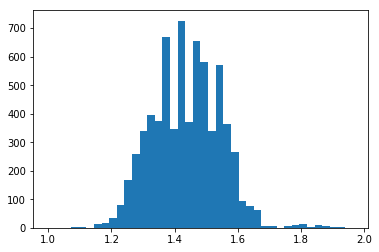

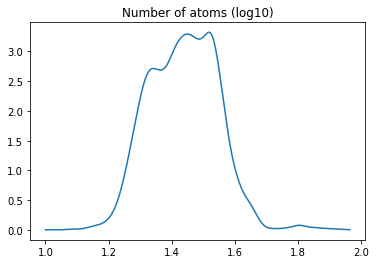

In [10]:
plt.hist(np.log10([x.GetNumAtoms() for x in df_molecules_std.mol]), bins=40)
plt.figure()
plot_kde(np.log10([x.GetNumAtoms() for x in df_molecules_std.mol]))
plt.title('Number of atoms (log10)')

Text(0.5, 1.0, 'activity')

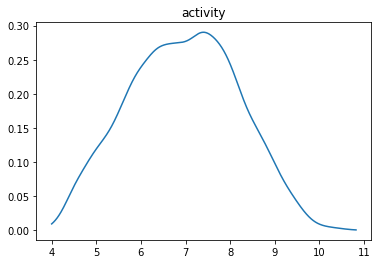

In [11]:
plot_kde(df_join.activity)
plt.title('activity')

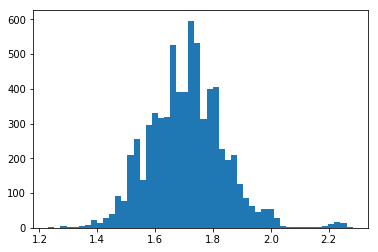

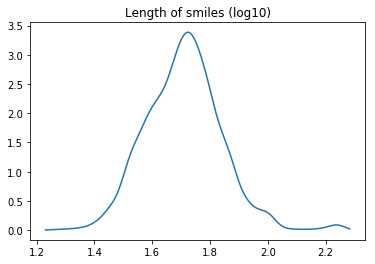

In [12]:
plt.hist(np.log10(list(map(len,df_molecules_std.std_smiles))), bins=50)
plt.figure()
plot_kde(np.log10(list(map(len,df_molecules_std.std_smiles))))
plt.title('Length of smiles (log10)');

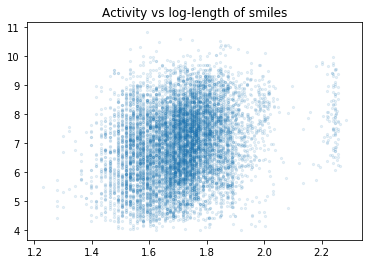

In [13]:
plt.scatter(np.log10(list(map(len,df_join.std_smiles))), df_join.activity, alpha=0.1, s=5)
plt.title('Activity vs log-length of smiles');

Text(0.5, 1.0, 'Activity vs log-length of smiles')

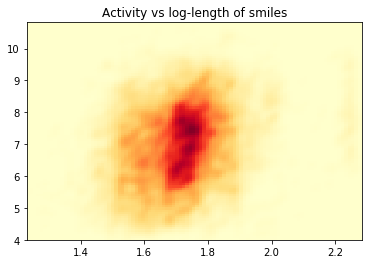

In [14]:
plot_kde_2d(np.log10(list(map(len,df_join.std_smiles))), df_join.activity, num_points=100, bw_method=0.1, cmap='YlOrRd')
plt.title('Activity vs log-length of smiles')

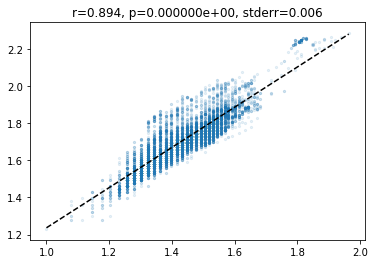

In [15]:
plot_linear_regression(np.log10([MolFromSmiles(x).GetNumAtoms() for x in df_join.std_smiles]), np.log10(list(map(len,df_join.std_smiles))), alpha=0.1, s=5)
# plt.title('Length of smiles vs Number of atoms (log-log)')

# Analysis of promiscuity

In [16]:
df_activity_wide = df_join.reset_index().pivot('std_inchi_key','receptor_name')['activity'].copy()

In [17]:
df_activity_wide.head()

receptor_name,AR,ERa,ERb,GR,MR,PR
std_inchi_key,,,,,,
AABLNHSZFIPOBJ-UHFFFAOYSA-N,NaN,NaN,NaN,7.51,NaN,NaN
AACVSEPXXNRBIR-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,7.79
AADGIVANXMJZCW-HFPMIOGFSA-N,NaN,NaN,NaN,NaN,6.075,NaN
AAFYPWXCJRYVKV-ILTCGSTDSA-N,NaN,NaN,NaN,9.05,NaN,NaN
AAJNWJFLYOFHIB-UHFFFAOYSA-N,NaN,NaN,NaN,7.77,6.500,6.85


In [18]:
df_activity_wide_t = df_activity_wide.applymap(lambda x:x if np.isnan(x) else [0.0,1.0][x>7])

In [19]:
display(df_activity_wide.corr(method='pearson').style.background_gradient(cmap='Blues'))
display(df_activity_wide_t.corr(method='pearson').style.background_gradient(cmap='Blues'))

receptor_name,AR,ERa,ERb,GR,MR,PR
receptor_name,,,,,,
AR,1,0.381635,0.43549,0.203375,0.076974,0.195173
ERa,0.381635,1,0.555438,0.182496,-0.078861,0.724338
ERb,0.43549,0.555438,1,0.275847,-0.366357,0.731444
GR,0.203375,0.182496,0.275847,1,-0.0106831,0.113676
MR,0.076974,-0.078861,-0.366357,-0.0106831,1,0.0477185
PR,0.195173,0.724338,0.731444,0.113676,0.0477185,1


receptor_name,AR,ERa,ERb,GR,MR,PR
receptor_name,,,,,,
AR,1,0.429844,0.229117,0.0906014,-0.0681465,0.150546
ERa,0.429844,1,0.283025,0.221958,-0.250743,0.560449
ERb,0.229117,0.283025,1,0.148964,-0.223607,0.592157
GR,0.0906014,0.221958,0.148964,1,-0.161473,-0.0406103
MR,-0.0681465,-0.250743,-0.223607,-0.161473,1,0.0582286
PR,0.150546,0.560449,0.592157,-0.0406103,0.0582286,1


In [20]:
r1,r2='ERa,PR'.split(',')
(df_activity_wide[[r1,r2]].query('{}.notnull() and {}.notnull()'.format(r1,r2))>7).corr(method='pearson')

receptor_name,ERa,PR
receptor_name,,
ERa,1.000000,0.560449
PR,0.560449,1.000000


In [21]:
df_ttest = df_activity_wide.corr().copy()
for r1 in df_ttest.columns:
    for r2 in df_ttest.columns:
        if r1 == r2:
            t,p = None,1
        else:
            df = df_activity_wide_t[[r1,r2]].query('{}.notnull() and {}.notnull()'.format(r1,r2))
            a,b = df[r1],df[r2]
            df_ttest[r1][r2] = np.sum(np.logical_and(a, b))/np.sum(a)
#             df_ttest[r1][r2] = np.sum(a*b)/np.sum(a)

df_ttest.style.background_gradient(cmap='Blues')

receptor_name,AR,ERa,ERb,GR,MR,PR
receptor_name,,,,,,
AR,1,0.705882,0.483871,0.235294,0.178571,0.324841
ERa,0.5,1,0.561558,0.590909,0.166667,0.769231
ERb,0.576923,0.720968,1,0.4375,0.142857,0.625
GR,0.627451,0.65,0.583333,1,0.57971,0.628743
MR,0.322581,0.125,0.166667,0.160643,1,0.351351
PR,0.593023,0.8,0.909091,0.283784,0.262626,1


# Analysis of ERa ligands

In [22]:
df_era = df_join.query('receptor_name == "ERa"').copy()

In [23]:
df_era['active'] = df_era.Standard_Value < 100

In [24]:
fps          = np.asarray([np.frombuffer(fp.encode('ASCII'), np.byte) - ord('0') for fp in df_era.std_morgan_fp])
scaffold_fps = np.asarray([np.frombuffer(fp.encode('ASCII'), np.byte) - ord('0') for fp in df_era.scaffold_morgan_fp])

## Principal component analysis

In [25]:
pca = PCA()
pc = pca.fit_transform(fps)
pca_scaffold = PCA()
pc_scaffold = pca_scaffold.fit_transform(scaffold_fps)

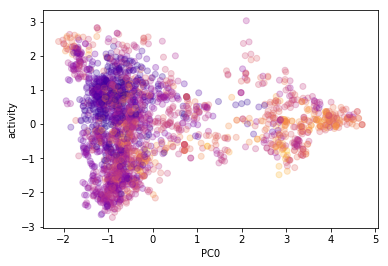

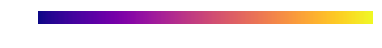

In [26]:
plt.xlabel('PC0')
plt.ylabel('activity')
plot_scatter_colormap(pc[:,0], pc[:,1], df_era.activity)

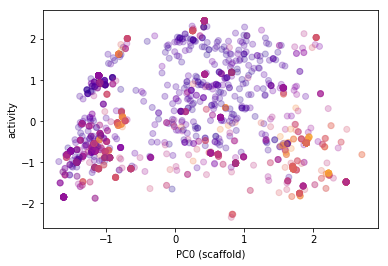

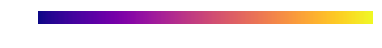

In [27]:
plt.xlabel('PC0 (scaffold)')
plt.ylabel('activity')
plot_scatter_colormap(pc_scaffold[:,0], pc_scaffold[:,1],df_era.activity)

## Principal component regression analysis

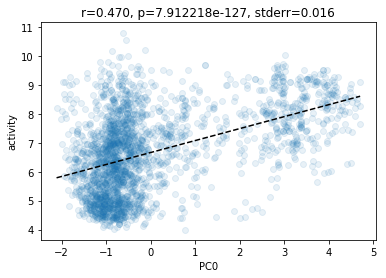

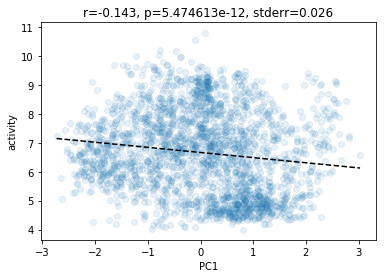

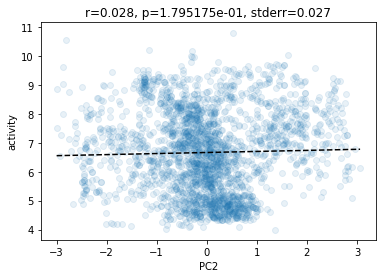

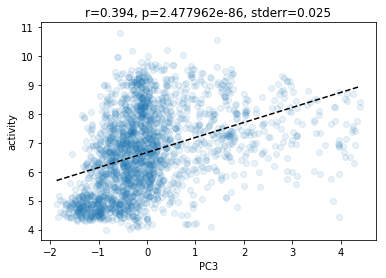

In [28]:
for i in range(4):
    plt.figure()
    plot_linear_regression(pc[:,i], df_era.activity)
    plt.xlabel('PC%d' % i)
    plt.ylabel('activity')

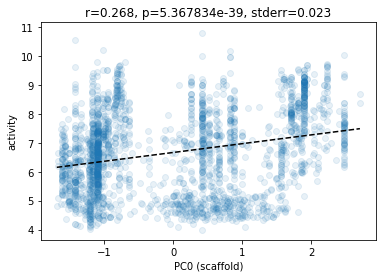

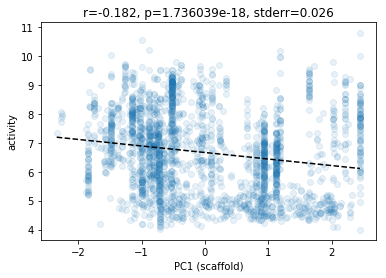

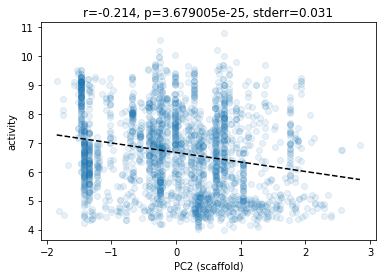

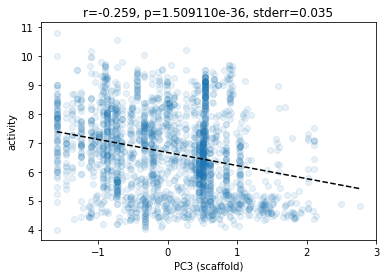

In [29]:
for i in range(4):
    plt.figure()
    plot_linear_regression(pc_scaffold[:,i], df_era.activity)
    plt.xlabel('PC%d (scaffold)' % i)
    plt.ylabel('activity')

# Linear regression on whole fingerprint

In [30]:
lr = LinearRegression()
lr.fit(fps, df_era.activity)
r2 = lr.score(fps, df_era.activity)
np.sqrt(r2)

0.935026300203313

In [31]:
lr = LinearRegression()
lr.fit(scaffold_fps, df_era.activity)
r2 = lr.score(scaffold_fps, df_era.activity)
np.sqrt(r2)

0.8051933988593978

In [32]:
rs = []
for nc in tqdm_notebook(range(1,300)):
    lr = LinearRegression()
    lr.fit(pc[:,:nc], df_era.activity)
    r2 = lr.score(pc[:,:nc], df_era.activity)
    rs.append(np.sqrt(r2))

In [33]:
rs_scaffold = []
for nc in tqdm_notebook(range(1,300)):
    lr = LinearRegression()
    lr.fit(pc_scaffold[:,:nc], df_era.activity)
    r2 = lr.score(pc_scaffold[:,:nc], df_era.activity)
    rs_scaffold.append(np.sqrt(r2))

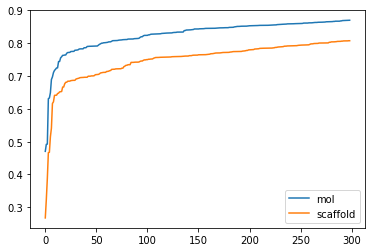

In [34]:
plt.plot(np.asarray(rs)**1, label='mol')
plt.plot(np.asarray(rs_scaffold)**1, label='scaffold')
plt.legend()

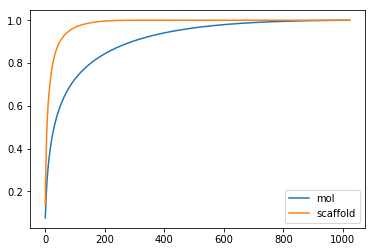

In [35]:
plt.plot(list(accumulate(pca.explained_variance_ratio_)), label='mol')
plt.plot(list(accumulate(pca_scaffold.explained_variance_ratio_)), label='scaffold')
plt.legend()